In [1]:
import sys; sys.path.append('../src')

from input_output.parser import Parser
from input_output.writer import Writer
from preprocessing.tokenizer import *
from models.rules import classify_token, classify_tokens
import pandas as pd
from preprocessing.tokenizer import tokens2sent, tokenize_embed
from preprocessing.transformations import *
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from preprocessing.transformations import CRF_get_tag
from os import path, listdir
import numpy as np
import matplotlib
#matplotlib.use('Agg')
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Using TensorFlow backend.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\John.Souarlis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\John.Souarlis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\John.Souarlis\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 1000)

In [3]:
bank_type = 'NER'
bank_name = 'DrugBank'
#dir_type = f'Test-{bank_type}'
dir_type = f'Train'
bank_dir = f'../resources/{dir_type}/{bank_name}/'

In [4]:
df = Parser(bank_dir).call()

In [5]:
df['tokens'] = df['sentence'].apply(tokenize)
df['crf_tags'] = df[['tokens', 'parsed_drugs']].apply(CRF_get_tag, axis=1)

In [6]:
tk, df['tokens_emb'] = tokenize_embed(df['tokens'])
tk_class, df['labels'] = labelEncode(df['crf_tags'])

In [7]:
max_len = df['tokens_emb'].apply(len).max()
df = removeEmptyRows(df)
#df = removeSpecialCases(df)

df['tokens_emb'] = padList(df['tokens_emb'], 0, max_len)

df['labels'] = padList(df['labels'], tk_class.word_index['o'], max_len)

In [8]:
print(df.shape)
df.head()

(5531, 8)


,id,sentence,parsed_drugs,parsed_pairs,tokens,crf_tags,tokens_emb,labels
0,DDI-DrugBank.d436.s0,"No drug, nutritional supplement, food or herb interactions have yet been reported.",[],[],"[{'text': 'no', 'char_offset': [0, 1]}, {'text': 'drug', 'char_offset': [3, 6]}, {'text': ',', 'char_offset': [7, 7]}, {'text': 'nutritional', 'char_offset': [9, 19]}, {'text': 'supplement', 'char_offset': [21, 30]}, {'text': ',', 'char_offset': [31, 31]}, {'text': 'food', 'char_offset': [33, 36]}, {'text': 'or', 'char_offset': [38, 39]}, {'text': 'herb', 'char_offset': [41, 44]}, {'text': 'interactions', 'char_offset': [46, 57]}, {'text': 'have', 'char_offset': [59, 62]}, {'text': 'yet', 'char_offset': [64, 66]}, {'text': 'been', 'char_offset': [68, 71]}, {'text': 'reported', 'char_offset': [73, 80]}, {'text': '.', 'char_offset': [81, 81]}]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[35, 39, 1, 3018, 1504, 1, 888, 14, 2473, 56, 23, 1505, 21, 64, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,DDI-DrugBank.d519.s0,No formal drug/drug interaction studies with Plenaxis were performed.,[<DrugEntity DDI-DrugBank.d519.s0.e0 45-52 Plenaxis brand>],[],"[{'text': 'no', 'char_offset': [0, 1]}, {'text': 'formal', 'char_offset': [3, 8]}, {'text': 'drug/drug', 'char_offset': [10, 18]}, {'text': 'interaction', 'char_offset': [20, 30]}, {'text': 'studies', 'char_offset': [32, 38]}, {'text': 'with', 'char_offset': [40, 43]}, {'text': 'plenaxis', 'char_offset': [45, 52]}, {'text': 'were', 'char_offset': [54, 57]}, {'text': 'performed', 'char_offset': [59, 67]}, {'text': '.', 'char_offset': [68, 68]}]","[O, O, O, O, O, O, B-brand, O, O, O]","[35, 420, 2474, 59, 53, 7, 1868, 51, 308, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,DDI-DrugBank.d519.s1,Cytochrome P-450 is not known to be involved in the metabolism of Plenaxis.,[<DrugEntity DDI-DrugBank.d519.s1.e0 66-73 Plenaxis brand>],[],"[{'text': 'cytochrome', 'char_offset': [0, 9]}, {'text': 'p-450', 'char_offset': [11, 15]}, {'text': 'is', 'char_offset': [17, 18]}, {'text': 'not', 'char_offset': [20, 22]}, {'text': 'known', 'char_offset': [24, 28]}, {'text': 'to', 'char_offset': [30, 31]}, {'text': 'be', 'char_offset': [33, 34]}, {'text': 'involved', 'char_offset': [36, 43]}, {'text': 'in', 'char_offset': [45, 46]}, {'text': 'the', 'char_offset': [48, 50]}, {'text': 'metabolism', 'char_offset': [52, 61]}, {'text': 'of', 'char_offset': [63, 64]}, {'text': 'plenaxis', 'char_offset': [66, 73]}, {'text': '.', 'char_offset': [74, 74]}]","[O, O, O, O, O, O, O, O, O, O, O, O, B-brand, O]","[110, 936, 15, 17, 111, 8, 11, 889, 6, 4, 82, 3, 1868, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,

In [9]:
words = df['tokens'].apply(lambda el_lst: pd.Series([el['text'] for el in el_lst])).stack().unique()
word2idx = {w: i + 1 for i, w in enumerate(words)}

In [10]:
tags = df['crf_tags'].apply(lambda el_lst: pd.Series(el_lst)).stack().unique()
tag2idx = {t: i for i, t in enumerate(tags)}

In [11]:
len(tags), len(words)

(9, 6706)

In [12]:
X = [[word2idx[w['text']] for w in s] for s in df['tokens']]

In [13]:
n_words = len(words)
n_tags = len(tags)

In [14]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

In [15]:
y = [[tag2idx[t] for t in s] for s in df['crf_tags']]

In [16]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [17]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [18]:
n_words, df.shape, df['tokens'].apply(len).sum()

(6706, (5531, 8), 118291)

In [19]:
sum(df['crf_tags'].apply(lambda x: len([i for i in x if i[0] == 'B']))) #- df['parsed_drugs'].apply(len))

12645

In [55]:
drug_ents = df.apply(lambda x: pd.Series(x['parsed_drugs']),axis=1).stack()
drug_id = drug_ents.apply(lambda x: x.id)
drug_names = drug_ents.apply(lambda x: x.text)
drug_type = drug_ents.apply(lambda x: x.type)
df_drug = pd.concat([drug_id, drug_names, drug_type], axis=1)
df_drug.reset_index(drop=True, inplace=True)
df_drug.columns = ['id', 'drug', 'type']

In [56]:
print(len(df_drug['drug'].unique()), df_drug.shape)
df_drug.head()

2655 (12929, 3)


,id,drug,type
0,DDI-DrugBank.d519.s0.e0,Plenaxis,brand
1,DDI-DrugBank.d519.s1.e0,Plenaxis,brand
2,DDI-DrugBank.d519.s2.e0,Plenaxis,brand
3,DDI-DrugBank.d519.s3.e0,Plenaxis,brand
4,DDI-DrugBank.d519.s3.e1,testosterone,drug


In [22]:
most_common_drugs = drug_names.value_counts()[:20].index
len(most_common_drugs)
unfolded_most_common_drugs = drug_names[drug_names.isin(most_common_drugs)].apply(lambda x: pd.Series(x.lower().split())).stack().unique()

## Embeddings dist

In [24]:
from input_output.load_config import load_config_file
config = load_config_file('../src/config.json', './')

In [388]:
w_dir = '../resources/glove/weights2'
w_files = [f for f in listdir(w_dir) if 'pub' in f]
w_files

['weights_emb_pub.npy']

In [389]:
#for wf in w_files:
weights = np.load(path.join(w_dir,w_files[0]))
print(weights.shape)
word_dict = {}
drug_unique = df_drug['drug'].value_counts()
for w, w_ind in word2idx.items():
    #if w in unfolded_most_common_drugs:
    word_dict[w] = weights[w_ind,:]
len(word_dict)

(6708, 200)


6706

In [390]:
interacts = ['admin', 'antidepress', 'becaus', 'caut', 'coadmin', 'concomit', 'dos', 'drug', 'effect', 'hour', 'inhibit', 'may', 'monit', 'oth',
            'paty',   'pot',   'receiv',   'recommend',   'tak',   'therapy',   'theref',   'thi', 'acid',   'act',   'addit',   'admin',   'alcohol',   'aminoglycosid',   'anesthet',   'antibiot',   
            'anticholinerg',   'anticoag',   'antidepress',   'antihistamin',   'antihypertend',   'barbit',   'benzodiazepin', 
            'block',   'blood',   'caus',   'cent',   'certain',   'chloral',   'cns',   'combin',   'concomit',   'concur', 
            'decreas',   'depress',   'determin',   'diet',   'diuret',   'dos',   'drug',   'effect',   'enh',   'gen',   'hav',  
            'high',   'hypotend',   'includ',   'increas',   'indomethacin',   'inhibit',   'interact',   'lith',   'man',   'may', 
            'monoamin',   'narcot',   'nerv',   'neuromuscul',   'oth',   'oxidas',   'paty',   'phenothiazin',   'phenytoin',   'potenty', 
            'produc',   'prolong',   'prothrombin',   'quinidin',   'receiv',   'reduc',   'report',   'respons',   'result',   'salicyl',  
            'salt',   'sed',   'sod',   'som',   'steroid',   'sulfonamid',   'system',   'tim',   'tranquil',   'tricyc',   'unrely',  
            'warfarin', 'cyclosporin', 'drug', 'interact', 'may', 'med', 'absorb',   'acid',   'admin',   'alprazolam',   'antacid',   'approxim',   'auc',   'bind',   'calc',   'carbamazepin', 
            'cimetidin',   'clear',   'coadmin',   'concomit',   'cont',   'contain',   'contraceiv',   'cyclosporin',   'day', 
            'decreas',   'diazepam',   'digoxin',   'dos',   'drug',   'effect',   'enzym',   'equetrotm',   'erythromycin',
            'ethosuximid',   'expect',   'follow',   'found',   'hav',   'increas',   'induc',   'inhibit',   'interact',   'itraconazol',
            'ketoconazol',   'level',   'low',   'may',   'metabol',   'midazolam',   'oth',   'paty',   'phenobarbit',   'phenytoin',
            'plasm',   'probenecid',   'produc',   'proteas',   'quinolon',   'reduc',   'report',   'result',   'ser',   'study',
            'theophyllin',   'triazolam',   'valpro',   'warfarin']

50 6706


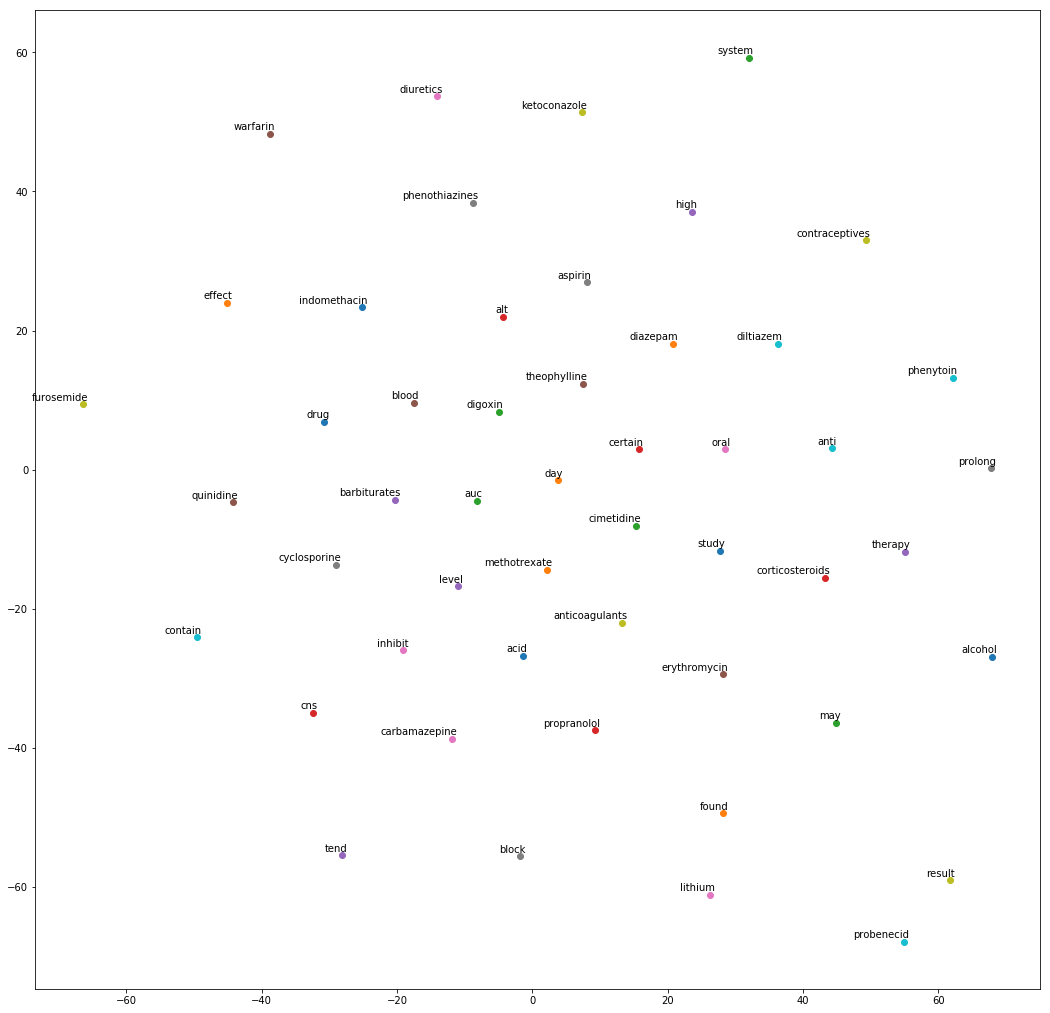

In [391]:
import string
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                 va='bottom')
    plt.show()
    #plt.savefig(filename)

# pylint: disable=g-import-not-at-top
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 50
c = 0
wrds = []
embs = []
word2look = []
index2look = []
emb2look = []
stop = False
for wrd, emb in word_dict.items():
    wrds.append(wrd)
    embs.append(emb)
    #if wrd not in string.punctuation and wrd not in stop_words and not wrd in string.digits or wrd:
    for w_inter in interacts:
        if c >= plot_only:
            stop = True
            break
        if ((wrd in w_inter and wrd not in string.punctuation and wrd not in stop_words and len(wrd)>2) or 
            (wrd.lower() in drug_unique.index[:35])) and wrd not in word2look:
            c += 1
            word2look.append(wrd)
            index2look.append(wrds.index(wrd))
            emb2look.append(emb)

    #if stop:
    #    break
print(len(word2look), len(wrds))

low_dim_embs = tsne.fit_transform(emb2look)
labels = word2look
plot_with_labels(low_dim_embs, labels, 'tsne.png')

In [392]:
from sklearn.metrics.pairwise import pairwise_distances
mat = pairwise_distances(list(embs))
np.fill_diagonal(mat, np.inf)
min_0 = np.argsort(mat,axis=0)#np.argmin(mat,axis=0)

for i,item in zip(index2look, word2look):#enumerate(list(word_dict.keys())[:20]):
    print(str(item)+' '+str(np.array(wrds)[min_0[:,i][:4]]))

drug ['mechanism' 'reports' 'due' 'bolus']
day ['starting' 'interactions' 'drug/drug' 'studies']
may ['also' 'inc' 'a' 'harm']
corticosteroids ['injection' '17b' 'didanosine' 'restriction']
therapy ['anticholinergic-containing' 'efficacy' 'magnesium' 'inc.']
warfarin ['standard' 'delaying' 'heparin' 'vr']
oral ['3-hour' 'that' '8' 'ect']
aspirin ['sgot' 'nonprescription' 'atp' 'monitoring']
anticoagulants ['11-fold' 'cystic' 'lines' 'erpf']
anti ['testosterone' '400' 'pathways' 'narrow']
alcohol ['251' 'non-ossification' 's.d' 'fenbufen']
diazepam ['norethindrone' 'hivid' 'preferably' 'proton']
auc ['n' 'intervention' 'href=' 'receptor-positive']
certain ['described' 'alleviate' 'consequences' 'creatine']
tend ['produce' 'applied' 'rats' 'grade']
blood ['supplement' 'delayed' 'compete' 'similar']
diuretics ['limited' 'theoretically' 'sub-' 'device']
phenothiazines ['conflicting' 'device' 'marked' 'familial']
contraceptives ['gestation' 'skills' 'hot' 'glatiramer']
phenytoin ['possessin

In [32]:
def print_dist(item):
    i = list(word_dict.keys()).index(item)
    print(str(item)+' '+str(np.array(list(word_dict.keys()))[min_0[:,i][:6]]))
print_dist('decrease')
print_dist('abciximab')
print_dist('increasing')
print_dist('testosterone')
print_dist('angiotensin')
print_dist('antagonists')


decrease ['healthy' 'dose' 'volunteers' 'atovaquone' 'abciximab' 'potentiating']
abciximab ['experience' 'atovaquone' 'blunting' 'dose' 'increasing' 'distribution']
increasing ['distribution' 'ischemic' 'abciximab' 'nabumetone' 'notably' 'experience']
testosterone ['anti' 'concomitant' 'these' 'pathways' 'departure' 'bromide']
angiotensin ['table' 'pituitary-gonadal' 'kits' 'reserve' 'initiation' 'steroid']
antagonists ['fluphenazine' 'vecuronium' 'sympathetic' 'biloba' '95' 'butorphanol']


## Find pairs

In [81]:
drug_pairs = df.apply(lambda x: pd.Series(x['parsed_pairs']),axis=1).stack()
#drug_id = drug_pairs.apply(lambda x: x.id)
drug_ent1 = drug_pairs.apply(lambda x: x.entity_1)
drug_ent2 = drug_pairs.apply(lambda x: x.entity_2)
pair_type = drug_pairs.apply(lambda x: x.type)
df_pair = pd.concat([drug_ent1, drug_ent2, pair_type], axis=1)
df_pair.reset_index(drop=True, inplace=True)
df_pair.columns = ['drug1', 'drug2', 'type']

In [82]:
df_pair = df_pair[df_pair['type'].notnull()].reset_index(drop=True)
df_pair.head()

,drug1,drug2,type
0,DDI-DrugBank.d297.s3.e0,DDI-DrugBank.d297.s3.e1,effect
1,DDI-DrugBank.d297.s4.e0,DDI-DrugBank.d297.s4.e1,advise
2,DDI-DrugBank.d297.s5.e0,DDI-DrugBank.d297.s5.e1,advise
3,DDI-DrugBank.d0.s2.e0,DDI-DrugBank.d0.s2.e1,mechanism
4,DDI-DrugBank.d0.s6.e0,DDI-DrugBank.d0.s6.e1,effect
5,DDI-DrugBank.d536.s4.e0,DDI-DrugBank.d536.s4.e5,mechanism
6,DDI-DrugBank.d536.s4.e1,DDI-DrugBank.d536.s4.e5,mechanism
7,DDI-DrugBank.d536.s4.e3,DDI-DrugBank.d536.s4.e5,mechanism
8,DDI-DrugBank.d536.s4.e4,DDI-DrugBank.d536.s4.e5,mechanism
9,DDI-DrugBank.d536.s5.e0,DDI-DrugBank.d536.s5.e1,mechanism


In [102]:
df_pair.shape

(3788, 3)

In [93]:
drug1 = df_drug[df_drug['id'].isin(drug_ent1)]
drug2 = df_drug[df_drug['id'].isin(drug_ent2)]

In [104]:
drug_names1 = df_pair[['drug1']].merge(drug1, left_on='drug1', right_on='id')['drug']
drug_names2 = df_pair[['drug2']].merge(drug2, left_on='drug2', right_on='id')['drug']

In [106]:
df_pair['drug1'] = drug_names1
df_pair['drug2'] = drug_names2
df_pair.head()

,drug1,drug2,type
0,TNF antagonist,ORENCIA,effect
1,ORENCIA,TNF antagonists,advise
2,ORENCIA,anakinra,advise
3,naltrexone,Acamprosate,mechanism
4,Acamprosate,antidepressants,effect


In [119]:
df_pair[df_pair.isin({'drug1':['methotrexate'], 'drug2':['methotrexate']}).any(axis=1)]


,drug1,drug2,type
33,methotrexate,etretinate,effect
34,methotrexate,acitretin,advise
64,methotrexate,PROLEUKIN,effect
476,ELSPAR,methotrexate,effect
477,methotrexate,ELSPAR,advise
1213,Probenecid,methotrexate,mechanism
1277,methotrexate,ciprofloxacin,mechanism
1278,methotrexate,ciprofloxacin,advise
1743,diclofenac,methotrexate,mechanism
1747,diclofenac,methotrexate,effect


## Model Loss

In [373]:
from os import path
w_dir = '../src/results'
w_files = [f for f in listdir(w_dir) if 'baseline' in f and 'png' not in f]
w_files

['baseline_20', 'baseline_200', 'baseline_50']

In [378]:
df_loss = pd.DataFrame()
for file,dim in zip(w_files,[20,200,50]):#['glove200', 'glove50', 'pubmed200']):
    file_path = path.join(w_dir, file)
    loss = pd.DataFrame(np.load(path.join(file_path, 'f1s.npy')), columns=['f1s_%s' %(dim)])
    #val_loss = pd.DataFrame(np.load(path.join(file_path, 'val_loss.npy')), columns=['val_loss_%s' %(dim)])
    #df_tmp = pd.concat([loss,val_loss], axis=1)
    df_loss = pd.concat([df_loss, loss], axis=1)
df_loss -= 0.1
df_loss.head()

,f1s_20,f1s_200,f1s_50
0,0.646404,0.811475,0.744240
1,0.746426,0.841700,0.819030
2,0.805816,0.838370,0.782444
3,0.776722,0.845382,0.814753
4,0.768911,0.810231,0.787103


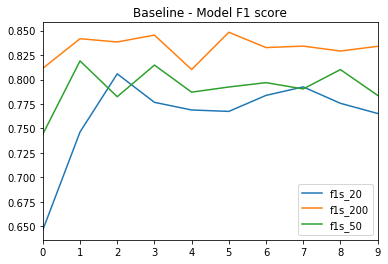

In [379]:
df_loss.plot()
plt.title('Baseline - Model F1 score')
plt.savefig('../src/results/baseline_model_f1s.png')

## Emb loss

In [341]:
from os import path
w_dir = '../src/results_emb'
w_files = [f for f in listdir(w_dir) if 'baseline' in f and 'png' not in f]
w_files

[]

In [325]:
df_loss = pd.DataFrame()
for file,dim in zip(w_files,[200,20,50]):#,20,20,20,50,50,50]):
    file_path = path.join(w_dir, file)
    loss = pd.DataFrame(np.load(path.join(file_path)), columns=['loss_cb_%s' %(dim)])
    df_loss = pd.concat([df_loss, loss], axis=1)
df_loss.head()

,loss_cb_10,loss_cb_2,loss_cb_5
0,39793.382812,41766.242188,37370.429688
1,3386.429688,3683.941406,4091.703125
2,2276.996094,2237.257812,2172.078125
3,1753.917969,1561.984375,1446.945312
4,1429.351562,1373.652344,1004.273438


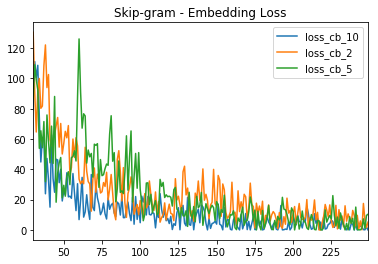

In [326]:
df_loss.iloc[-220:,:].plot()
plt.title('Skip-gram - Embedding Loss')
plt.savefig('../src/results_emb/sg_emb_loss.png')

## Results

In [247]:
df = pd.read_csv('../src/results_exp.csv',header=0)
df.head()

,Out File,Type,File,LR,Window,Dim,Max len,Tr loss,Tst loss,Tr acc,Tst acc,F1s Test
0,weights_emb_simple_20_0.001,simple,NaN,0.001,0,20,165,0.008829,27.524983,0.995503,27.524983,0.508000
1,weights_emb_simple_50_0.001,simple,NaN,0.001,0,50,165,0.004518,27.511664,0.998132,27.511664,0.548000
2,weights_emb_simple_200_0.001,simple,NaN,0.001,0,200,165,0.002525,27.489161,0.999126,27.489161,0.645291
3,weights_emb_sg_20_2_0.5_4,w2v_sg,NaN,0.500,2,20,165,0.015092,27.551062,0.994213,27.551062,0.564706
4,weights_emb_sg_50_2_0.5_4,w2v_sg,NaN,0.500,2,50,165,0.015773,27.552993,0.994150,27.552993,0.508159


In [248]:
df['Name'] = df['Type'] + '_d' + df['Dim'].apply(str) + '_w'+df['Window'].apply(str) 

In [251]:
df1 = df[['Name','Tr loss', 'Test loss', 'F1s Test']]
df1.to_csv('../src/output_test.csv')